In [8]:
import sys
import os

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sys.path.append('code/')
from linear_utils import is_float

In [84]:
# RESULTS_DIR = os.path.join("P:/early_stopping_double_descent", "...") # enter folder direction here (i.e., two_layer_results)
RESULTS_DIR = "results/one_layer_results" #"five_layer_regression_results"

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def get_all_files(lr, batch_norm, uniform_noise, coupled_noise=None, ext=''):
    files = os.listdir(RESULTS_DIR)
    files = [file for file in files if file.startswith(f'lr={lr}')]

    if batch_norm:
        files = [file for file in files if "batch_norm" in file]
    elif uniform_noise:
        files = [file for file in files if "uniform_noise" in file]    
    else:
        files = [file for file in files if "batch_norm" and "uniform_noise" not in file]
        
    # Sorry, I will clean this up eventually
    if coupled_noise is not None:
        files = [file for file in files if f"coupled_noise_{coupled_noise}" in file]  
        
    files = [file for file in files if ext in file]

    return files

def get_files(batch_norm):
    files = os.listdir(RESULTS_DIR)
    files = [file for file in files if file.endswith(".csv")]
    if batch_norm:
        files = [file for file in files if "batch_norm" in file]
    else:
        files = [file for file in files if "batch_norm" not in file]
    return files

def append_id(filename, id):
    return "{0}_{2}.{1}".format(*filename.rsplit('.', 1) + [id])

def get_filename_individual(lr1, lr2, batch_norm):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    linear = result_path_split[-1] == "linear"
    if linear:
        w = '_'.join(result_path_split[-3:-1])
    else:
        w = '_'.join(result_path_split[-2:])
    
    name = f'lr1={lr1}_lr2={lr2}_w={w}.pdf'
    
    if batch_norm:
        name = append_id(name, "batch_norm")
    if linear:
        name = append_id(name, "linear")
    return name

def get_filename_range(lr1, lr2_low, lr2_high, batch_norm, uniform_noise=False):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    linear = result_path_split[-1] == "linear"
    if linear:
        w = '_'.join(result_path_split[-3:-1])
    else:
        w = '_'.join(result_path_split[-2:])
    
    name = f'lr1={lr1}_lr2_low={lr2_low}_lr2_high=_{lr2_high}_w={w}.pdf'
    
    if batch_norm:
        name = append_id(name, "batch_norm")
    elif uniform_noise:
        name = append_id(name, "uniform_noise")

    if linear:
        name = append_id(name, "linear")
        
    return name

def plot_individual_run(lr1, lr2, batch_norm, uniform_noise=False, coupled_noise=None, ext=''):
    file_path = os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}.csv")
    if batch_norm:
        file_path = append_id(file_path, "batch_norm") 
    elif uniform_noise:
        file_path = append_id(file_path, "uniform_noise") 
        
    if coupled_noise is not None:
        file_path = append_id(file_path, f"coupled_noise_{coupled_noise}") 
        
    file_path = append_id(file_path, ext)
    
    data = pd.read_csv(file_path, header=None)
    geo_samples = [int(i) for i in np.geomspace(1, len(data) - 1, num=700)]
    cmap = matplotlib.colormaps['viridis']
    colorList = [cmap(50 / 1000), cmap(350 / 1000)]
    labelList = ['same stepsize', 'scaled stepsize']

    #fig = plt.figure()
    fig, ax = plt.subplots(2, 1, sharex=True)
    for k in range(2):
        ax[k].set_xscale('log')
        data_vec = data[k]
        ax[k].plot(geo_samples, data_vec[geo_samples],
            color=colorList[k],
            label=labelList[k],
            lw=4)

    plt.suptitle(fr"$\eta_{{\mathbf{{W}}}} = {lr1}$, $\eta_{{\mathbf{{v}}}} = {lr2}$")
    
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    plt.savefig(os.path.join(save_dir, get_filename_individual(lr1, lr2, batch_norm)))
    plt.show()
    

def get_filename(lr, vmax, batch_norm):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    linear = result_path_split[-1] == "linear"
    if linear:
        w = '_'.join(result_path_split[-3:-1])
    else:
        w = '_'.join(result_path_split[-2:])
    
    name = f'{lr}_vmax={vmax}_w={w}.pdf'
    if batch_norm:
        name = append_id(name, "batch_norm")
    if linear:
        name = append_id(name, "linear")
        
    return name

def plot_results(lr, vmax=20, vmin=0, keep_nan=True, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', plot_nans=False, num_its=50000):
    files = get_all_files(lr, batch_norm, uniform_noise, coupled_noise, ext)
    
    if not isinstance(vmax, list):
        vmax = [vmax] * 2
    if not isinstance(vmin, list):
        vmin = [vmin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
        lrs = [f.split('_')[1] for f in files]
    elif uniform_noise:
        f_ext = "_uniform_noise"
        lrs = [f.split('_')[1] for f in files]        
    else:
        f_ext = ""
        lrs = [f.split('_')[-1][:-4] for f in files]
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext + ".csv"
    
    #assert len(lrs) == 99, "Something wrong with the amount of files"
    lrs_float = [float(l) for l in lrs]
    lrs_float, lrs = zip(*sorted(zip(lrs_float, lrs)))
    
    risks = np.zeros((len(lrs), num_its))
    losses = np.zeros((len(lrs), num_its))
    for i, l in enumerate(lrs):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr}_{l}{f_ext}"), header=None)
        risks[i] = data[0]
        losses[i] = data[1]
    if (~np.isfinite(risks)).any() and np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0].any():
        print(r"Lr2 with nan/inf, then some lower lr2")
        idx=np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0][-1] + 1
        for j in range(10):
            if plot_nans:
                plot_individual_run(lr, lrs[idx-j], batch_norm)
            else:
                print(lrs[idx-j])
    else:
        print('No nans/inf values')
    ratios = np.array(lrs_float)/lr
            
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, 50000 - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)

    # Plot
    im1 = ax[0].imshow(risks[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[0], vmin=vmin[0])
    im2 = ax[1].imshow(losses[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[1], vmin=vmin[1])
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"$\eta_{{\mathbf{{W}}}}={lr}$"
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    ten_powers = 10.0 ** np.arange(-5, 6)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(ratios-val))]
    
    for k in [1]:
        ax[k].set_xticks(indices)
        ax[k].set_xticklabels([f"$10^{{{i}}}$" for i in np.arange(-5, 6)])
        ax[k].set_xlabel(r"$\eta_{\mathbf{v}} / \eta_{\mathbf{W}}$")
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    # Save file
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    
    figname = get_filename(lr, vmax[0], batch_norm)
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    return

def plot_same_lr(vmax=20, batch_norm=False):
    files = get_files(batch_norm)
    if batch_norm:
        f_ext = "_batch_norm.csv"
        lrs = [f.split('_')[1] for f in files]
    else:
        f_ext = ".csv"
        lrs = [f.split('_')[-1][:-4] for f in files]
        
    assert len(lrs) == 91, "Not right amount of files"
    lrs_float = [float(l) for l in lrs]
    lrs_float, lrs = zip(*sorted(zip(lrs_float, lrs)))
    risks = np.zeros((len(lrs), 50000))
    losses = np.zeros((len(lrs), 50000))
    for i, lr in enumerate(lrs):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr}_{lr}{f_ext}"), header=None)
        risks[i] = data[0]
        losses[i] = data[1]
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, 50000 - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)
    # Plot
    im1 = ax[0].imshow(risks[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax)
    fig.colorbar(im1, ax=ax[0])
    im2 = ax[1].imshow(losses[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax)
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"Same lr for both layers"
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    ten_powers = 10.0 ** np.arange(-7, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(lrs_float-val))]
    
    ax[1].set_xticks(indices)
    ax[1].set_xticklabels([f"$10^{{{i}}}$" for i in np.arange(-7, -1)])
    ax[1].set_xlabel("lr")
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    figname = get_filename(lr, vmax, batch_norm)
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    
    

In [63]:
# Function for plotting a selection of curves

def plot_individual_runs_range(lr1, lr_ratio_low, lr_ratio_high, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', ymin=[0, 0], ymax = [50, 150000]):
    """Plot individual runs within range lr_ratio_low to lr_ratio_high"""
    
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext)
        
    if batch_norm:
        f_ext = "_batch_norm"
        lrs = [f.split('_')[1] for f in files]
    elif uniform_noise:
        f_ext = "_uniform_noise"
        lrs = [f.split('_')[1] for f in files]
    else:
        f_ext = ""
        lrs = [f.split('_')[-1][:-4] for f in files]
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext + ".csv"
    
    # Keep runs only within range
    lr2_low, lr2_high = lr_ratio_low * lr1, lr_ratio_high * lr1
    # files = [f for f, lr in zip(files, lrs) if float(lr) >= lr2_low and float(lr) <= lr2_high]
    lrs = [float(lr) for lr in lrs if float(lr) >= lr2_low and float(lr) <= lr2_high]
    lrs.sort()

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,10))
    ylabels = ["Test loss", "Training loss"]
    for i, lr in enumerate(lrs):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr}{f_ext}"), header=None)       
        geo_samples = [int(i) for i in np.geomspace(1, len(data) - 1, num=700)]

        for k in range(2):
            if i == 0:
                ax[k].set_xscale('log')
                ax[k].set_ylim([ymin[k], ymax[k]])
                ax[k].set_ylabel(ylabels[k])
            
            data_vec = data[k] 
            ax[k].plot(geo_samples, data_vec[geo_samples],
#                color=colorList[k],
                lw=2)
            
    ax[0].legend([fr"$\eta_{{\mathbf{{v}}}} = {lr2}$" for lr2 in lrs], loc=2)
    fig.suptitle(fr"$\eta_{{\mathbf{{w}}}} = {lr1}$")

    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  

    plt.savefig(os.path.join(save_dir, get_filename_range(lr1, lr2_low, lr2_high, batch_norm, uniform_noise)))
    plt.show()
    


Lr2 with nan/inf, then some lower lr2
0.00542867544
0.0042919342600000005
0.0033932217700000005
0.0026826958000000004
0.00212095089
0.00167683294
0.00132571137
0.00104811313
0.000828642773
0.000655128557


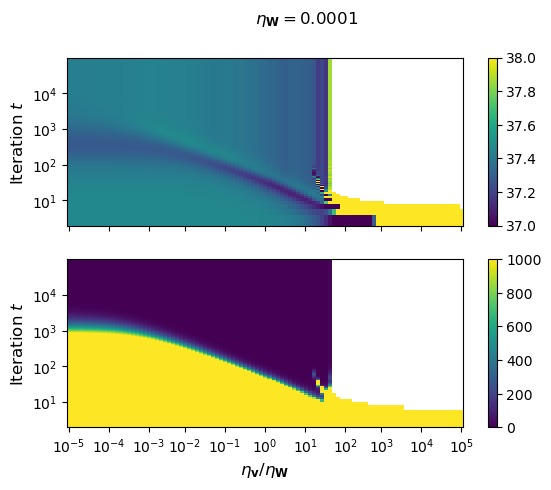

In [57]:
plot_results(1e-4, vmax=[38, 1000], vmin=[37, 0], batch_norm=False, uniform_noise=True, coupled_noise=50.0, ext='_dim_100', plot_nans=False, num_its=100001)

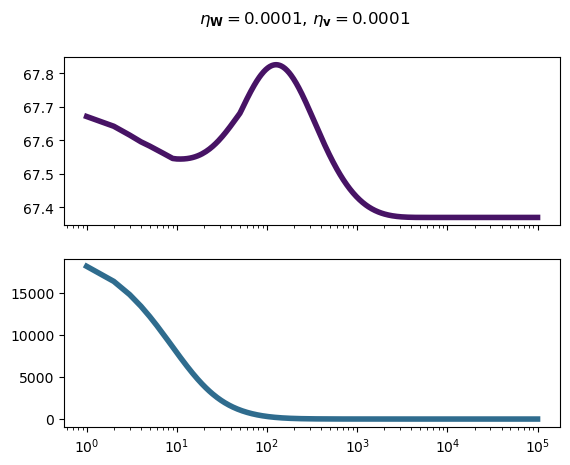

In [90]:
plot_individual_run(1e-4, 1e-4, batch_norm=False, uniform_noise=True, coupled_noise=100.0, ext='dim_150')

In [ ]:
for eta_w in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    plot_results(eta_w, 20, plot_nans=False, batch_norm=False)

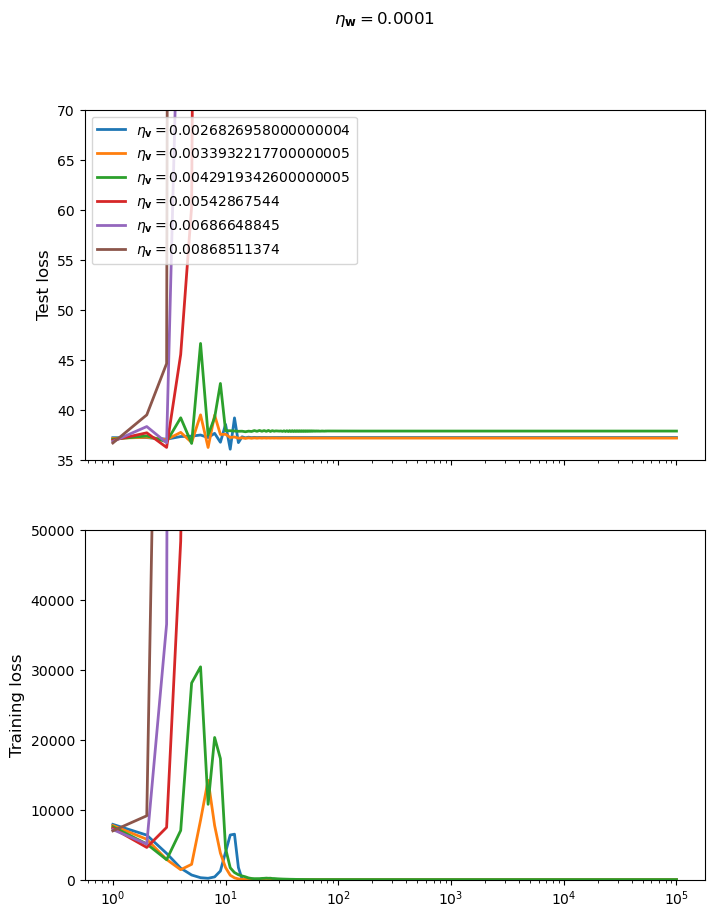

In [83]:
plot_individual_runs_range(1e-4, 25, 100, batch_norm=False, uniform_noise=True, coupled_noise=50.0, ext='_dim_100', ymin=[35, 0], ymax=[70, 50000])